<a href="https://colab.research.google.com/github/RiddhimGupta/MachineLearning/blob/master/EmotionAwareMusicPlayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
angry_data = 'gdrive/My Drive/dataset/angry'
happy_data = 'gdrive/My Drive/dataset/happy'
neutral_data = 'gdrive/My Drive/dataset/neutral'
sad_data = 'gdrive/My Drive/dataset/sad'

In [0]:
##############################################
#CAPTURE IMAGE#
##############################################
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import time

import numpy as np
import tensorflow as tf

def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
				input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

def main(img):
  file_name = img
  model_file = "retrained_graph.pb"
  label_file = "retrained_labels.txt"
  input_height = 224
  input_width = 224
  input_mean = 128
  input_std = 128
  input_layer = "input"
  output_layer = "final_result"

  parser = argparse.ArgumentParser()
  parser.add_argument("--image", help="image to be processed")
  parser.add_argument("--graph", help="graph/model to be executed")
  parser.add_argument("--labels", help="name of file containing labels")
  parser.add_argument("--input_height", type=int, help="input height")
  parser.add_argument("--input_width", type=int, help="input width")
  parser.add_argument("--input_mean", type=int, help="input mean")
  parser.add_argument("--input_std", type=int, help="input std")
  parser.add_argument("--input_layer", help="name of input layer")
  parser.add_argument("--output_layer", help="name of output layer")
  args = parser.parse_args()

  if args.graph:
    model_file = args.graph
  if args.image:
    file_name = args.image
  if args.labels:
    label_file = args.labels
  if args.input_height:
    input_height = args.input_height
  if args.input_width:
    input_width = args.input_width
  if args.input_mean:
    input_mean = args.input_mean
  if args.input_std:
    input_std = args.input_std
  if args.input_layer:
    input_layer = args.input_layer
  if args.output_layer:
    output_layer = args.output_layer

  graph = load_graph(model_file)
  t = read_tensor_from_image_file(file_name,
                                  input_height=input_height,
                                  input_width=input_width,
                                  input_mean=input_mean,
                                  input_std=input_std)

  input_name = "import/" + input_layer
  output_name = "import/" + output_layer
  input_operation = graph.get_operation_by_name(input_name);
  output_operation = graph.get_operation_by_name(output_name);


  with tf.Session(graph=graph) as sess:
    start = time.time()
    results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: t})
    end=time.time()
  results = np.squeeze(results)

  top_k = results.argsort()[-5:][::-1]
  labels = load_labels(label_file)

  for i in top_k:
    return labels[i]


In [5]:
!python retrain.py --output_graph=retrained_graph.pb --output_labels=retrained_labels.txt --architecture=MobileNet_1.0_224 --image_dir=images

W0726 21:14:58.264244 140222537369472 deprecation_wrapper.py:119] From retrain.py:1257: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0726 21:14:58.264952 140222537369472 deprecation_wrapper.py:119] From retrain.py:901: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0726 21:14:58.265118 140222537369472 deprecation_wrapper.py:119] From retrain.py:901: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0726 21:14:58.265232 140222537369472 deprecation_wrapper.py:119] From retrain.py:772: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0726 21:14:58.265364 140222537369472 deprecation_wrapper.py:119] From retrain.py:773: The name tf.gfile.DeleteRecursively is deprecated. Please use tf.io.gfile.rmtree instead.

W0726 21:14:58.265636 140222537369472 deprecation_wrapper.py:119] From retrain.py:774: The name tf.gfile.MakeDirs is depreca

In [0]:
!python label_image.py

<IPython.core.display.Javascript object>

Saved to photo.jpg


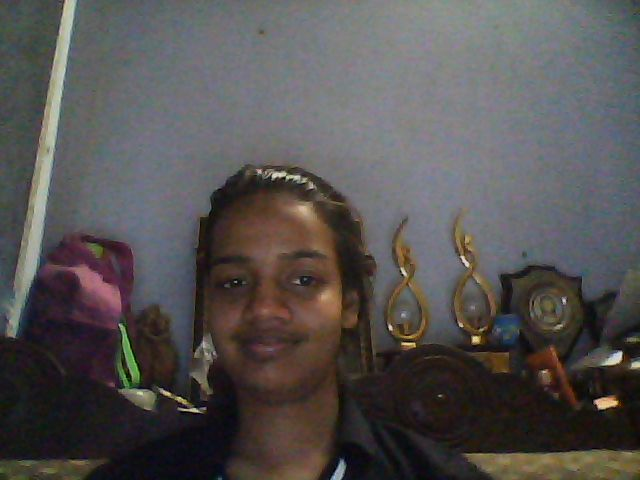

usage: ipykernel_launcher.py [-h] [--image IMAGE] [--graph GRAPH]
                             [--labels LABELS] [--input_height INPUT_HEIGHT]
                             [--input_width INPUT_WIDTH]
                             [--input_mean INPUT_MEAN] [--input_std INPUT_STD]
                             [--input_layer INPUT_LAYER]
                             [--output_layer OUTPUT_LAYER]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-dd02955d-0aeb-4c07-83af-a5bdc39fe339.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
import cv2
from IPython.display import Image
import numpy

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

from PIL import Image
img = Image.open("photo.jpg")
transposed_img = img.transpose(Image.FLIP_LEFT_RIGHT)
transposed_img.save('photo.jpg')
img = Image.open("photo.jpg")
im = numpy.asarray(img)
    
    # Resize the image to speed up detection
    #mini = cv2.resize(im, (int(im.shape[1]/size), int(im.shape[0]/size)))
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)
cv2.imwrite("tesqt.jpg", clahe_image)
 #To run classifier 
face = classifier.detectMultiScale(clahe_image, scaleFactor=1.1, minNeighbors=15, minSize=(10, 10), flags=cv2.CASCADE_SCALE_IMAGE)
#To draw rectangle around detected face
for (x, y, w, h) in face:
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 0, 255), 2)    
    #Save just the rectangle faces in SubRecFaces
    faceslice = im[y:y+h, x:x+w]
    #draw it on "frame", (coordinates), (size), (RGB color), thickness 2    
    cv2.imwrite("test.jpg", faceslice)
    text =main("test.jpg")
    text = text.title()# Title Case looks Stunning.
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(im, text,(x+w,y), font, 1, (0,0,255), 2)
    # Show the image
cv2.imwrite("capture.jpg", im)
#key = cv2.waitKey(10)
    
    # if Esc key is press then break out of the loop
#if key == 27:#The Esc key
  # break
